In [1]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p drive/MyDrive/bayer

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/bfg-dataset.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/tomato/yellow_leaf_curl_virus/e3332e6d-d444-4f60-9e7c-571ffaea6c82___UF.GRC_YLCV_Lab 01989.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e346fbf7-5888-423a-b2c6-ff67dd1e3b3f___YLCV_GCREC 2166.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e3479b46-d8bb-4c56-ad22-3364f19761cb___YLCV_NREC 2850.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e34c6884-cf13-49cb-aac4-06d77e4c1155___YLCV_GCREC 2350.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e35801a0-5554-4e50-8e86-4a9f599411cb___YLCV_NREC 0265.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e3650c26-1c04-4ed1-bd66-a77da126216f___UF.GRC_YLCV_Lab 01344.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e37881e6-7e58-4e4d-b07e-0b90102d5fdc___YLCV_GCREC 5188.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e37a58dc-6b69-4955-8dda-1561f8b0db77___UF.GRC_YLCV_Lab 02025.JPG  
  inflating: data/tomato/yellow_leaf_curl_virus/e3aa7c50-b3d4

In [3]:
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

     \ 348kB 6.2MB/s
  Created wheel for torchsampler: filename=torchsampler-0.1.1-cp37-none-any.whl size=3801 sha256=c03b0ae1e0842f72bbd8ddd52b01e7393e9975b483f56616d855bdf936d4c064
  Stored in directory: /tmp/pip-ephem-wheel-cache-bm94olyi/wheels/c1/f1/dc/587588aa0a5f0dc76673d98a554ff4db2575aaca3984240ec1
Successfully built torchsampler


In [4]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=9d0c38f7646c055b203f68e590aef4888b3d1daa161b454c2e08595787105c91
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [5]:
!pip install --upgrade albumentations

     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 38.2MB 80kB/s 
     |████████████████████████████████| 952kB 41.4MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr
from efficientnet_pytorch import EfficientNet
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_TRANSFORM = A.Compose([
    A.Flip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.3, hue=0, p=0.5),
    A.Blur(blur_limit=4, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

TEST_TRANSFORM = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

TARGETS = ["bacterial_spot", "black_measles", "black_mold", "black_rot", "black_spot", "blast", "blight", "brown_spot", "canker", "dot", "early_blight", "gray_spot", "greening", "healthy", "late_blight", "leaf_mold", "leaf_scorch", "melanose", "miner", "mosaic_virus", "mummification", "powdery_mildew", "rust", "scab", "scald", "septoria_leaf_spot", "spot", "target_spot", "tungro", "two_spotted_spider_mite", "virus", "yellow_leaf_curl_virus"]

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = "data/" + self.df.loc[idx, "img_id"].replace("\\", "/")

        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            img = self.transform(image=img)["image"]

        return torch.tensor(img.transpose((2, 0, 1))), torch.tensor(self.df.loc[idx, TARGETS])

    def get_label(self, idx):
        return self.df.loc[idx, "condition"]

In [9]:
df = pd.read_csv("data/data_additional2.csv")

In [10]:
dataset = {
    "train": MyDataset(df[df["split"] == "train"], transform=TEST_TRANSFORM),
    "dev": MyDataset(df[df["split"] == "dev"], transform=TEST_TRANSFORM),
    "test": MyDataset(df[df["split"] == "test"], transform=TEST_TRANSFORM),
}

In [11]:
dataloader = {
    "train": DataLoader(dataset["train"], batch_size=64, num_workers=2, pin_memory=True),
    "dev": DataLoader(dataset["dev"], batch_size=64, num_workers=2, pin_memory=True),
    "test": DataLoader(dataset["test"], batch_size=64, num_workers=2, pin_memory=True),
}

In [12]:
model = EfficientNet.from_pretrained("efficientnet-b5", num_classes=len(TARGETS)).to(DEVICE)
model.load_state_dict(torch.load("drive/MyDrive/bayer2/best.pth", map_location=DEVICE))
model = model.eval()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


In [13]:
criterion = nn.BCEWithLogitsLoss()

In [14]:
def compute_metrics(split="test"):
    avg_loss = 0

    labels = np.zeros((0, len(TARGETS)))
    preds = np.zeros((0, len(TARGETS)))

    with torch.no_grad():
        for x, y in tqdm(dataloader[split]):
            x = x.to(DEVICE)
            y = y.to(DEVICE, torch.float)

            y_pred = model(x)

            labels = np.concatenate((labels, y.cpu().detach().numpy()))
            preds = np.concatenate((preds, torch.sigmoid(y_pred).cpu().detach().numpy()))

            loss = criterion(y_pred, y)
            avg_loss += loss.item() / len(dataloader[split])

    f1_micro = f1_score(labels, preds > 0.5, average="micro")
    f1_macro = f1_score(labels, preds > 0.5, average="macro")

    return avg_loss, f1_micro, f1_macro

In [ ]:
compute_metrics("train")

(0.010093863569589117, 0.9513925462374918, 0.9411305498975019)

In [ ]:
compute_metrics("dev")

(0.012087335726391757, 0.9422266303000248, 0.8362757001539625)

In [ ]:
compute_metrics("test")

(0.011161593475662812, 0.9464219273223367, 0.8653509039773195)

In [15]:
!curl -o test1.jpg "https://tomathouse.com/wp-content/uploads/2018/09/bakterialnaya-pyatnistost-listya-2.jpg"
!curl -o test2.jpg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTzp7wrXvX4dJPdvElmAnuGVc3ekuadpmsQEg&usqp=CAU"
!curl -o test3.jpg "https://www.backyardworkshop.com/wp-content/uploads/2017/02/Brown-Spots-on-Tomato-Leaves.jpg"
!curl -o test4.jpg "https://cdn8.dissolve.com/p/D869_27_632/D869_27_632_1200.jpg"
!curl -o test5.jpg "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F37%2F2020%2F04%2F22%2Fseptoria-spot-tomato-plant-ea2ab44d.jpg"
!curl -o test6.jpg "https://www.tomatogrowing.co.uk/newsletter/wp-content/uploads/2013/02/NewGrowth.jpg"
!curl -o test7.jpg "https://images.wagwalkingweb.com/media/articles/cat/tomato-plant-poisoning/tomato-plant-poisoning.jpg"
!curl -o test8.jpg "https://gardenerspath.com/wp-content/uploads/2019/12/Close-Up-of-Lemons.jpg"
!curl -o test9.jpg "https://gardenerspath.com/wp-content/uploads/2020/09/How-to-Eradicate-Sooty-Mold-From-Your-Plants-Cover.jpg"
!curl -o test10.jpg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKKJfk2Iiz3zyMdQYnqfBiuEl0cA-cZQfO8Q&usqp=CAU"
!curl -o test11.jpg "http://extension.msstate.edu/sites/default/files/publication-images/P3175/Fig._8.jpg"
!curl -o test12.jpg "https://www.nature-and-garden.com/wp-content/uploads/sites/4/2019/08/septoria.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  115k  100  115k    0     0   178k      0 --:--:-- --:--:-- --:--:--  177k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7628  100  7628    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79278    0 79278    0     0   374k      0 --:--:-- --:--:-- --:--:--  374k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  110k  100  110k    0     0   619k      0 --:--:-- --:--:-- --:--:--  619k
  % Total    % Received % Xferd  Average Speed   Tim

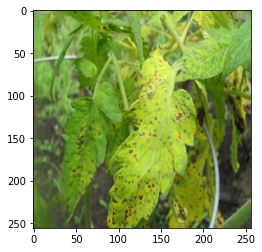

tensor(17) tensor(0.7464) melanose
[('bacterial_spot', 0.00016967814008239657), ('black_measles', 6.62888414808549e-05), ('black_mold', 4.951548180542886e-05), ('black_rot', 2.6754505597637035e-05), ('black_spot', 0.000127101200632751), ('blast', 0.0029844772070646286), ('blight', 0.019930405542254448), ('brown_spot', 0.0008998732664622366), ('canker', 0.003937766887247562), ('dot', 8.292882739624474e-06), ('early_blight', 0.000694204238243401), ('gray_spot', 5.2081039029872045e-05), ('greening', 0.00016429476090706885), ('healthy', 0.014161291532218456), ('late_blight', 0.0007260182173922658), ('leaf_mold', 0.0005037428345531225), ('leaf_scorch', 0.003430058714002371), ('melanose', 0.7463827729225159), ('miner', 4.454363534023287e-06), ('mosaic_virus', 0.0009764280403032899), ('mummification', 1.9107321804767707e-06), ('powdery_mildew', 0.002045422326773405), ('rust', 0.00010610479512251914), ('scab', 0.0005422444082796574), ('scald', 1.7758679859980475e-06), ('septoria_leaf_spot', 0.

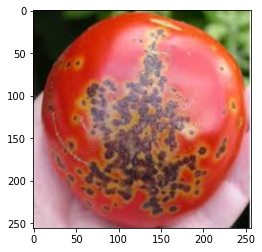

tensor(16) tensor(0.7861) leaf_scorch
[('bacterial_spot', 0.0020633521489799023), ('black_measles', 3.064839120270335e-07), ('black_mold', 5.959218015050283e-06), ('black_rot', 2.8065383958164603e-05), ('black_spot', 0.000147024926263839), ('blast', 0.4301263391971588), ('blight', 0.019396107643842697), ('brown_spot', 0.008994647301733494), ('canker', 0.00048322981456294656), ('dot', 4.485430508793797e-06), ('early_blight', 0.0006054530385881662), ('gray_spot', 1.4458718396781478e-05), ('greening', 4.674252977565629e-06), ('healthy', 0.013606326654553413), ('late_blight', 0.005209103226661682), ('leaf_mold', 7.422381167998537e-05), ('leaf_scorch', 0.7860609889030457), ('melanose', 0.00013729727652389556), ('miner', 1.590409920027014e-05), ('mosaic_virus', 0.0027227182872593403), ('mummification', 4.3767474267042417e-07), ('powdery_mildew', 0.016111768782138824), ('rust', 0.0010616143699735403), ('scab', 0.0032640998251736164), ('scald', 2.112033689627424e-05), ('septoria_leaf_spot', 0.

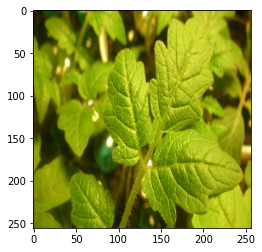

tensor(13) tensor(0.7033) healthy
[('bacterial_spot', 0.0004788777732755989), ('black_measles', 1.0419334103062283e-05), ('black_mold', 0.0011890901951119304), ('black_rot', 5.388467980083078e-05), ('black_spot', 2.6473960588191403e-06), ('blast', 8.828953286865726e-05), ('blight', 0.17137816548347473), ('brown_spot', 0.009693698026239872), ('canker', 5.378984155868238e-07), ('dot', 3.2555016105106915e-07), ('early_blight', 0.0018291936721652746), ('gray_spot', 4.625077508535469e-06), ('greening', 0.0002194583648815751), ('healthy', 0.7032843828201294), ('late_blight', 0.02449752204120159), ('leaf_mold', 4.324284600443207e-05), ('leaf_scorch', 0.000653619586955756), ('melanose', 1.5804371287231334e-05), ('miner', 7.412994023070496e-07), ('mosaic_virus', 2.5825604097917676e-05), ('mummification', 2.3033053366816603e-06), ('powdery_mildew', 0.004742806777358055), ('rust', 2.141588629456237e-05), ('scab', 9.326987310487311e-06), ('scald', 1.0638922276484664e-06), ('septoria_leaf_spot', 1.

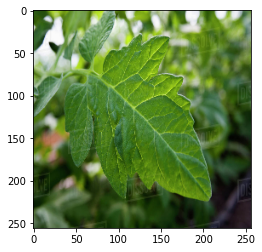

tensor(13) tensor(0.4113) healthy
[('bacterial_spot', 0.00024015696544665843), ('black_measles', 0.00032906862907111645), ('black_mold', 7.523647582274862e-06), ('black_rot', 0.00013421547191683203), ('black_spot', 2.3610948574059876e-06), ('blast', 0.0003682845854200423), ('blight', 0.010261262767016888), ('brown_spot', 0.0002800002694129944), ('canker', 0.004614534787833691), ('dot', 4.97555311085307e-06), ('early_blight', 6.148861575638875e-05), ('gray_spot', 0.00013481371570378542), ('greening', 0.011631667613983154), ('healthy', 0.41127049922943115), ('late_blight', 0.0025047124363482), ('leaf_mold', 3.136509985779412e-05), ('leaf_scorch', 0.00011106777674285695), ('melanose', 3.6658066164818592e-06), ('miner', 2.6855780106416205e-06), ('mosaic_virus', 2.42564819927793e-05), ('mummification', 0.004336001817137003), ('powdery_mildew', 0.17340804636478424), ('rust', 0.0004338212893344462), ('scab', 9.295251402363647e-06), ('scald', 1.425496876095167e-08), ('septoria_leaf_spot', 0.00

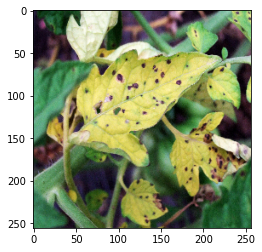

tensor(13) tensor(0.5226) healthy
[('bacterial_spot', 0.004659787751734257), ('black_measles', 9.538566700939555e-06), ('black_mold', 5.576249350269791e-06), ('black_rot', 0.0006962770712561905), ('black_spot', 3.555465809768066e-06), ('blast', 0.0016066617099568248), ('blight', 0.35425445437431335), ('brown_spot', 0.00012599081674125046), ('canker', 2.2829914087196812e-05), ('dot', 6.257536711018474e-07), ('early_blight', 0.001448551774956286), ('gray_spot', 2.3710254026809707e-06), ('greening', 0.004747139289975166), ('healthy', 0.5226386785507202), ('late_blight', 0.027004998177289963), ('leaf_mold', 0.00033471130882389843), ('leaf_scorch', 8.350743155460805e-05), ('melanose', 1.3638821656059008e-05), ('miner', 2.7827065878227586e-06), ('mosaic_virus', 0.00015034560055937618), ('mummification', 0.0018158943857997656), ('powdery_mildew', 0.0004795572895091027), ('rust', 0.00017883346299640834), ('scab', 9.967274309019558e-06), ('scald', 1.5810738887012121e-06), ('septoria_leaf_spot',

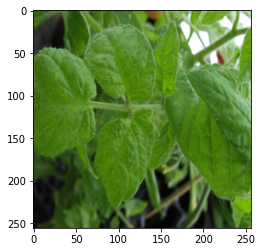

tensor(13) tensor(0.9790) healthy
[('bacterial_spot', 0.00016499776393175125), ('black_measles', 2.3480226445826702e-05), ('black_mold', 0.0011414450127631426), ('black_rot', 7.757471757940948e-05), ('black_spot', 2.8234671844984405e-06), ('blast', 2.675116411410272e-05), ('blight', 0.014550503343343735), ('brown_spot', 0.00014685273345094174), ('canker', 0.00010319497232558206), ('dot', 4.29175273097826e-08), ('early_blight', 0.0001890770363388583), ('gray_spot', 9.429670171812177e-06), ('greening', 0.011700880713760853), ('healthy', 0.9790184497833252), ('late_blight', 0.015197745524346828), ('leaf_mold', 9.403545845998451e-06), ('leaf_scorch', 9.311493340646848e-05), ('melanose', 1.725005313346628e-05), ('miner', 4.7085103460631217e-07), ('mosaic_virus', 6.327791197691113e-07), ('mummification', 2.0471014067879878e-05), ('powdery_mildew', 0.006981947924941778), ('rust', 1.930425969476346e-05), ('scab', 3.355990338604897e-05), ('scald', 1.481567721839383e-07), ('septoria_leaf_spot', 

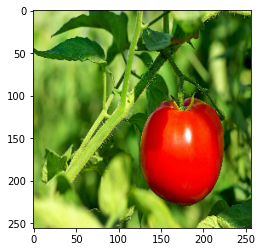

tensor(13) tensor(0.3808) healthy
[('bacterial_spot', 0.0022231985349208117), ('black_measles', 2.280754188177525e-06), ('black_mold', 0.005552749615162611), ('black_rot', 0.00011511171760503203), ('black_spot', 2.6296363557776203e-06), ('blast', 0.0010466559324413538), ('blight', 0.33912670612335205), ('brown_spot', 0.0003285141137894243), ('canker', 6.154255061119329e-06), ('dot', 2.674712504813215e-07), ('early_blight', 0.006294846069067717), ('gray_spot', 9.825041342992336e-05), ('greening', 0.014660326763987541), ('healthy', 0.380830317735672), ('late_blight', 0.054927028715610504), ('leaf_mold', 0.00019327731570228934), ('leaf_scorch', 1.1848640497191809e-05), ('melanose', 9.264489563065581e-06), ('miner', 3.257857315475121e-06), ('mosaic_virus', 1.797582081053406e-05), ('mummification', 0.00010393722914159298), ('powdery_mildew', 0.000664217455778271), ('rust', 2.336416582693346e-05), ('scab', 3.3708547562127933e-06), ('scald', 2.632632458698936e-06), ('septoria_leaf_spot', 3.54

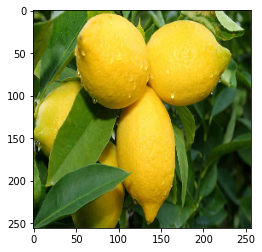

tensor(13) tensor(0.6309) healthy
[('bacterial_spot', 0.0016401439206674695), ('black_measles', 2.472960295563098e-05), ('black_mold', 0.00022167072165757418), ('black_rot', 0.0001946773991221562), ('black_spot', 0.00038956987555138767), ('blast', 0.0013211927143856883), ('blight', 0.052972059696912766), ('brown_spot', 0.0003183702356182039), ('canker', 0.010458377189934254), ('dot', 1.859971962403506e-05), ('early_blight', 0.000244211609242484), ('gray_spot', 9.958571354218293e-06), ('greening', 0.004269219469279051), ('healthy', 0.6309242844581604), ('late_blight', 0.004685452673584223), ('leaf_mold', 0.0004529954749159515), ('leaf_scorch', 0.00010119225044036284), ('melanose', 0.00014738537720404565), ('miner', 2.919008329627104e-05), ('mosaic_virus', 6.629389827139676e-05), ('mummification', 0.0008729824330657721), ('powdery_mildew', 0.00016745719767641276), ('rust', 0.0002349224960198626), ('scab', 0.0001011457497952506), ('scald', 2.81806514976779e-05), ('septoria_leaf_spot', 0.0

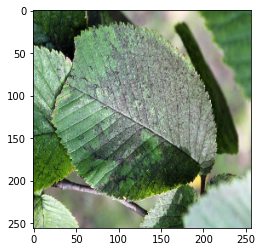

tensor(13) tensor(0.2146) healthy
[('bacterial_spot', 0.0002559656568337232), ('black_measles', 5.0834878493333235e-05), ('black_mold', 6.911571108503267e-05), ('black_rot', 0.00022207583242561668), ('black_spot', 1.138773495767964e-05), ('blast', 0.0027293828316032887), ('blight', 0.1125730648636818), ('brown_spot', 0.0005478355451487005), ('canker', 0.0008704300271347165), ('dot', 5.8544278545014095e-06), ('early_blight', 0.0012047929922118783), ('gray_spot', 3.5770044632954523e-06), ('greening', 0.0001917288900585845), ('healthy', 0.21463459730148315), ('late_blight', 0.011618013493716717), ('leaf_mold', 0.00016486489039380103), ('leaf_scorch', 0.06312433630228043), ('melanose', 6.5392698161304e-05), ('miner', 7.154464128689142e-06), ('mosaic_virus', 0.00010415958968224004), ('mummification', 0.00011932199413422495), ('powdery_mildew', 0.0018618894973769784), ('rust', 0.0002520497073419392), ('scab', 0.00018104085756931454), ('scald', 2.777184363367269e-06), ('septoria_leaf_spot', 0

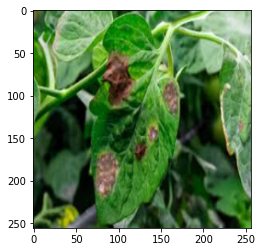

tensor(11) tensor(0.2877) gray_spot
[('bacterial_spot', 0.04204227775335312), ('black_measles', 0.00019661559781525284), ('black_mold', 0.0018353174673393369), ('black_rot', 0.00036589475348591805), ('black_spot', 3.2968791856546886e-06), ('blast', 0.05983017385005951), ('blight', 0.015257509425282478), ('brown_spot', 0.009003841318190098), ('canker', 1.4663050933449995e-05), ('dot', 1.0668442882888485e-05), ('early_blight', 0.2104298174381256), ('gray_spot', 0.287673681974411), ('greening', 4.925350003759377e-05), ('healthy', 0.0002492332423571497), ('late_blight', 0.00471613509580493), ('leaf_mold', 0.0008601536974310875), ('leaf_scorch', 0.00011002324754372239), ('melanose', 1.6975011021713726e-05), ('miner', 0.00010261474380968139), ('mosaic_virus', 0.0023044475819915533), ('mummification', 1.1732108760043047e-05), ('powdery_mildew', 0.0057421172969043255), ('rust', 0.0019724906887859106), ('scab', 0.0032347682863473892), ('scald', 8.399083890253678e-05), ('septoria_leaf_spot', 0.0

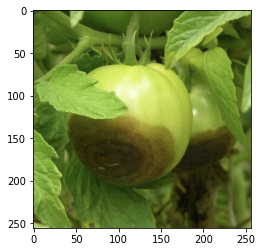

tensor(13) tensor(0.4055) healthy
[('bacterial_spot', 0.005702394060790539), ('black_measles', 1.4722241985509754e-06), ('black_mold', 0.00026356882881373167), ('black_rot', 5.942700227024034e-05), ('black_spot', 3.4053828130709007e-06), ('blast', 0.039838649332523346), ('blight', 0.0392594076693058), ('brown_spot', 0.000763750693295151), ('canker', 0.0013654010836035013), ('dot', 1.8711252778302878e-06), ('early_blight', 0.0018920772708952427), ('gray_spot', 1.0587409633444622e-05), ('greening', 0.007362186908721924), ('healthy', 0.40552985668182373), ('late_blight', 0.13337096571922302), ('leaf_mold', 6.734397175023332e-05), ('leaf_scorch', 0.0002905392611864954), ('melanose', 3.793733776547015e-05), ('miner', 5.0437711252016015e-06), ('mosaic_virus', 0.0002486477023921907), ('mummification', 5.559231340157567e-06), ('powdery_mildew', 0.01593768037855625), ('rust', 0.0001262629812117666), ('scab', 8.847790741128847e-05), ('scald', 2.5089273094636155e-06), ('septoria_leaf_spot', 0.000

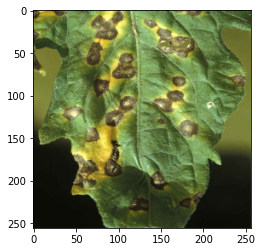

tensor(14) tensor(0.0703) late_blight
[('bacterial_spot', 0.0034430185332894325), ('black_measles', 1.4124610061116982e-05), ('black_mold', 0.04588558152318001), ('black_rot', 0.0002632646937854588), ('black_spot', 1.724883622955531e-05), ('blast', 0.03709006682038307), ('blight', 0.005403339397162199), ('brown_spot', 0.001094524166546762), ('canker', 0.010248844511806965), ('dot', 7.225107310659951e-06), ('early_blight', 0.029243266209959984), ('gray_spot', 0.00810674112290144), ('greening', 0.00038183515425771475), ('healthy', 0.00659495173022151), ('late_blight', 0.07031284272670746), ('leaf_mold', 0.0003803175641223788), ('leaf_scorch', 0.0001705820468487218), ('melanose', 6.355351797537878e-05), ('miner', 3.075626227655448e-05), ('mosaic_virus', 0.0008274342981167138), ('mummification', 1.8345432181376964e-05), ('powdery_mildew', 0.013925480656325817), ('rust', 0.0010305994655936956), ('scab', 0.0005206194473430514), ('scald', 8.854829502524808e-06), ('septoria_leaf_spot', 0.00036

In [18]:
for i in range(1, 13):
    img = cv2.imread("test" + str(i) + ".jpg")
    img = cv2.resize(img, (256, 256))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()

    img_tta_0 = TEST_TRANSFORM(image=img)["image"]
    img_tta_1 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_2 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_3 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_4 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_5 = TRAIN_TRANSFORM(image=img)["image"]

    with torch.no_grad():
        y_pred_0 = torch.sigmoid(model(torch.tensor([img_tta_0.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        #y_pred_1 = torch.sigmoid(model(torch.tensor([img_tta_1.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        #y_pred_2 = torch.sigmoid(model(torch.tensor([img_tta_2.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        #y_pred_3 = torch.sigmoid(model(torch.tensor([img_tta_3.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        #y_pred_4 = torch.sigmoid(model(torch.tensor([img_tta_4.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        #y_pred_5 = torch.sigmoid(model(torch.tensor([img_tta_5.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()

    #y_pred = (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5) / 5

    print(y_pred_0.argmax(), y_pred_0[0, y_pred_0.argmax()], TARGETS[y_pred_0.argmax(axis=1)])
    #print(y_pred, y_pred.argmax(), y_pred[0, y_pred.argmax()], TARGETS[y_pred.argmax(axis=1)])
    print(list(zip(TARGETS, y_pred_0.numpy()[0].tolist())))